In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle

In [3]:
file = open('/content/drive/MyDrive/IS_Assignment4/Data_Extracted/RML2016.10b.dat','rb')
Xd = pickle.load(file, encoding = 'bytes')
# get all mods and snrs from keys which are in form of (mod , snr)
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        # append different samples to X
        X.append(Xd[(mod,snr)])
        # add labels to all X values in previous step
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

In [4]:
#utility function for one hot
def mods_to_map():
  mods_map = {}
  for i in range(len(mods)):
    mods_map[mods[i]] = i
  
  return mods_map

In [5]:
def get_raw_features():
  return X

In [6]:
def get_dev_features(): # derivative features
  grad_channel_one = np.gradient(X[: , 0] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  grad_channel_two = np.gradient(X[: , 1] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  return np.hstack(( grad_channel_one , grad_channel_two ))

In [7]:
def get_integral_features(): # get integral features
  integral_channel_one = np.cumsum(X[: , 0] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  integral_channel_two = np.cumsum(X[: , 1] , axis=1).reshape(X.shape[0] , 1 , X.shape[2])
  return np.hstack(( integral_channel_one , integral_channel_two ))

In [8]:
def get_more_channels(): # all features 
  return np.hstack(( X , get_dev_features() , get_integral_features() ))

In [9]:
def one_hot(data_Y):

  data_Y = list(data_Y)

  mods_map = mods_to_map()
  
  one_hot_arr = np.zeros(( len(data_Y) , len(mods_map) ))

  for i in range (len(data_Y)):
    one_hot_arr[ i , mods_map[data_Y[i]] ] = 1
    
  print('done')
  return one_hot_arr

In [10]:
# data_X is array
def data_split(data_X):
  np.random.seed(0)
  data_no = data_X.shape[0]

  # split train by 70%
  train_no = int(data_no * 0.7)
  train_idx = np.random.choice(range(0 , data_no) , size=train_no , replace=False)
  
  # remaining index for test
  test_idx = list( set(range(0 , data_no)) - set(train_idx) )

  
  test_X = data_X[test_idx]
  test_Y = one_hot(map( lambda x: lbl[x][0] , test_idx))

  # split train to train(95%) and val(5%)
  val_no = int(train_no * 0.05)
  val_idx = np.random.choice(train_idx , size=val_no , replace=False)
  train_idx = list( set(train_idx) - set(val_idx) )

  train_X = data_X[train_idx]
  train_Y = one_hot(map( lambda x: lbl[x][0] , train_idx))

  val_X = data_X[val_idx]
  val_Y = one_hot(map( lambda x: lbl[x][0] , val_idx))


  return train_X , train_Y , val_X , val_Y , test_X , test_Y

#Logistic Regression Model

In [11]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

def get_accuracy(dataX, dataY, classifier):
  dataX = dataX.reshape((dataX.shape[0], dataX.shape[1] * dataX.shape[2]))
  
  dataY_hyp = classifier.predict(dataX)
  dataY = np.argwhere(dataY==1)[:,1]

  acc = 0.0
  for i in range(dataY.shape[0]):
    if dataY_hyp[i] == dataY[i]:
      acc = acc + 1
  acc = (acc / dataY.shape[0]) * 100
  return acc

##Raw data

In [12]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(X)

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1] * train_X.shape[2]))

train_Y = np.argwhere(train_Y==1)[:,1]

clf = LogisticRegression(random_state=0,max_iter=1000)
clf.fit(train_X, train_Y)

#saving model
pickle.dump(clf, open('/content/drive/MyDrive/IS_Assignment4/Models/logReg_raw.sav', 'wb'))

done
done
done


In [13]:
val_acc_raw = get_accuracy(val_X, val_Y, classifier=clf)
print("validation Accuracy: " + str(val_acc_raw))

validation Accuracy: 15.945238095238096


In [14]:
test_acc_raw = get_accuracy(test_X, test_Y, classifier=clf)
print("Test Accuracy: " + str(test_acc_raw))

Test Accuracy: 16.000555555555557


##First Derivative in Time

In [21]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_dev_features())

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1] * train_X.shape[2]))

train_Y = np.argwhere(train_Y==1)[:,1]

clf = LogisticRegression(random_state=0,max_iter=1000)
clf.fit(train_X, train_Y)

#saving model
pickle.dump(clf, open('/content/drive/MyDrive/IS_Assignment4/Models/logReg_dev.sav', 'wb'))

done
done
done


In [22]:
val_acc_dev = get_accuracy(val_X, val_Y, classifier=clf)
print("validation Accuracy: " + str(val_acc_dev))

validation Accuracy: 10.497619047619047


In [23]:
test_acc_dev = get_accuracy(test_X, test_Y, classifier=clf)
print("Test Accuracy: " + str(test_acc_dev))

Test Accuracy: 10.700555555555557


##Integral in Time

In [18]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_integral_features())

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1] * train_X.shape[2]))

train_Y = np.argwhere(train_Y==1)[:,1]

clf = LogisticRegression(random_state=0,max_iter=1000)
clf.fit(train_X, train_Y)

#saving model
pickle.dump(clf, open('/content/drive/MyDrive/IS_Assignment4/Models/logReg_integ.sav', 'wb'))

done
done
done


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [19]:
val_acc_integ = get_accuracy(val_X, val_Y, classifier=clf)
print("validation Accuracy: " + str(val_acc_integ))

validation Accuracy: 16.05


In [20]:
test_acc_integ = get_accuracy(test_X, test_Y, classifier=clf)
print("Test Accuracy: " + str(test_acc_integ))

Test Accuracy: 16.128055555555555


##Combinations of Raw Data, First Derivative and Integral (More Channels)

In [15]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_more_channels())

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1] * train_X.shape[2]))

train_Y = np.argwhere(train_Y==1)[:,1]

clf = LogisticRegression(random_state=0,max_iter=1000)
clf.fit(train_X, train_Y)

#saving model
pickle.dump(clf, open('/content/drive/MyDrive/IS_Assignment4//Models/logReg_moreChannels.sav', 'wb'))

done
done
done


In [16]:
val_acc_more_channels = get_accuracy(val_X, val_Y, classifier=clf)
print("validation Accuracy: " + str(val_acc_more_channels))

validation Accuracy: 15.980952380952381


In [17]:
test_acc_more_channels = get_accuracy(test_X, test_Y, classifier=clf)
print("Test Accuracy: " + str(test_acc_more_channels))

Test Accuracy: 16.065555555555555


#Fully Connected Layer

In [ ]:
import keras
import keras.models as models
from keras.layers import Dense, Reshape

##Raw data

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(X)

fc_model = models.Sequential()
fc_model.add(Reshape([256], input_shape=train_X.shape[1:]))
fc_model.add(Dense(1024, activation='relu'))
fc_model.add(Dense(10, activation='softmax'))
fc_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
fc_model.summary()

done
done
done
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10250     
Total params: 273,418
Trainable params: 273,418
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath = '/content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier.h5'
trained_fc = fc_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
              ])

Epoch 1/100
780/780 - 2s - loss: 1.9355 - acc: 0.2547 - val_loss: 1.7607 - val_acc: 0.3074

Epoch 00001: val_acc improved from -inf to 0.30740, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier.h5
Epoch 2/100
780/780 - 2s - loss: 1.7179 - acc: 0.3268 - val_loss: 1.6877 - val_acc: 0.3397

Epoch 00002: val_acc improved from 0.30740 to 0.33969, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier.h5
Epoch 3/100
780/780 - 2s - loss: 1.6701 - acc: 0.3508 - val_loss: 1.6581 - val_acc: 0.3563

Epoch 00003: val_acc improved from 0.33969 to 0.35629, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier.h5
Epoch 4/100
780/780 - 2s - loss: 1.6444 - acc: 0.3650 - val_loss: 1.6407 - val_acc: 0.3657

Epoch 00004: val_acc improved from 0.35629 to 0.36571, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier.h5
Epoch 5/100
780/780 - 2s - loss: 1.6266 - acc: 0.3723 - val_loss: 1.6299 - 

##First Derivative

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_dev_features())

fc_model = models.Sequential()
fc_model.add(Reshape([256], input_shape=train_X.shape[1:]))
fc_model.add(Dense(1024, activation='relu'))
fc_model.add(Dense(10, activation='softmax'))
fc_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

filepath = '/content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_dev.h5'
trained_fc = fc_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
              ])

done
done
done
Epoch 1/100
780/780 - 2s - loss: 2.2056 - acc: 0.1721 - val_loss: 2.0578 - val_acc: 0.1976

Epoch 00001: val_acc improved from -inf to 0.19764, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_dev.h5
Epoch 2/100
780/780 - 2s - loss: 1.9897 - acc: 0.2193 - val_loss: 1.9532 - val_acc: 0.2521

Epoch 00002: val_acc improved from 0.19764 to 0.25210, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_dev.h5
Epoch 3/100
780/780 - 2s - loss: 1.9222 - acc: 0.2493 - val_loss: 1.9113 - val_acc: 0.2459

Epoch 00003: val_acc did not improve from 0.25210
Epoch 4/100
780/780 - 2s - loss: 1.8858 - acc: 0.2742 - val_loss: 1.8853 - val_acc: 0.2636

Epoch 00004: val_acc improved from 0.25210 to 0.26362, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_dev.h5
Epoch 5/100
780/780 - 2s - loss: 1.8606 - acc: 0.2928 - val_loss: 1.8664 - val_acc: 0.2943

Epoch 00005: val_acc improved from 0.26362 to 

##Integral in Time

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_integral_features())

fc_model = models.Sequential()
fc_model.add(Reshape([256], input_shape=train_X.shape[1:]))
fc_model.add(Dense(1024, activation='relu'))
fc_model.add(Dense(10, activation='softmax'))
fc_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

filepath = '/content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_integ.h5'
trained_fc = fc_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
              ])

done
done
done
Epoch 1/100
780/780 - 2s - loss: 1.9062 - acc: 0.2562 - val_loss: 1.8137 - val_acc: 0.2849

Epoch 00001: val_acc improved from -inf to 0.28493, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_integ.h5
Epoch 2/100
780/780 - 2s - loss: 1.7734 - acc: 0.2934 - val_loss: 1.7354 - val_acc: 0.2992

Epoch 00002: val_acc improved from 0.28493 to 0.29919, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_integ.h5
Epoch 3/100
780/780 - 2s - loss: 1.7124 - acc: 0.3108 - val_loss: 1.6891 - val_acc: 0.3214

Epoch 00003: val_acc improved from 0.29919 to 0.32136, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_integ.h5
Epoch 4/100
780/780 - 2s - loss: 1.6709 - acc: 0.3253 - val_loss: 1.6525 - val_acc: 0.3320

Epoch 00004: val_acc improved from 0.32136 to 0.33198, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_integ.h5
Epoch 5/100
780/780 - 2s - loss: 1.6

##Combinations of Raw Data, First Derivative and Integral (More Channels)

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_more_channels())

fc_model = models.Sequential()
fc_model.add(Reshape([768], input_shape=train_X.shape[1:]))
fc_model.add(Dense(1024, activation='relu'))
fc_model.add(Dense(10, activation='softmax'))
fc_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

filepath = '/content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_more_channels.h5'
trained_fc = fc_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
              ])

done
done
done
Epoch 1/100
780/780 - 7s - loss: 1.8975 - acc: 0.2594 - val_loss: 1.7981 - val_acc: 0.2815

Epoch 00001: val_acc improved from -inf to 0.28155, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_more_channels.h5
Epoch 2/100
780/780 - 3s - loss: 1.7441 - acc: 0.3039 - val_loss: 1.7035 - val_acc: 0.3076

Epoch 00002: val_acc improved from 0.28155 to 0.30762, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_more_channels.h5
Epoch 3/100
780/780 - 3s - loss: 1.6681 - acc: 0.3279 - val_loss: 1.6434 - val_acc: 0.3410

Epoch 00003: val_acc improved from 0.30762 to 0.34105, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_more_channels.h5
Epoch 4/100
780/780 - 3s - loss: 1.6196 - acc: 0.3466 - val_loss: 1.6070 - val_acc: 0.3498

Epoch 00004: val_acc improved from 0.34105 to 0.34983, saving model to /content/drive/MyDrive/Neural_Net_Models/fully_concted_classifier_more_channels.h5
Epoc

#CNN Model

In [ ]:
import keras
import keras.models as models
from keras.layers import Dense, Reshape, Conv2D, Flatten, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

##Raw Data

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(X)

cnn_model = models.Sequential()
cnn_model.add(Reshape((2,128,1), input_shape=(2,128)))
cnn_model.add(Conv2D(64,(1,3),activation='relu'))
cnn_model.add(Conv2D(16,(2,3),activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dense(10,activation='softmax'))
cnn_model.compile(optimizer=Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['acc'])
cnn_model.summary()

done
done
done
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 126, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 124, 16)        6160      
_________________________________________________________________
flatten_4 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               254080    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 261,786
Trainable params: 261,786
Non-trainable params: 0
_________________________________

In [ ]:
filepath = '/content/drive/MyDrive/Neural_Net_Models/CNN_Raw.h5'
trained_fc = cnn_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
              ])

Epoch 1/100
780/780 - 7s - loss: 1.9357 - acc: 0.2356 - val_loss: 1.7133 - val_acc: 0.3062

Epoch 00001: val_acc improved from -inf to 0.30617, saving model to /content/drive/MyDrive/Neural_Net_Models/CNN_Raw.h5
Epoch 2/100
780/780 - 7s - loss: 1.5359 - acc: 0.3838 - val_loss: 1.4146 - val_acc: 0.4301

Epoch 00002: val_acc improved from 0.30617 to 0.43007, saving model to /content/drive/MyDrive/Neural_Net_Models/CNN_Raw.h5
Epoch 3/100
780/780 - 7s - loss: 1.3731 - acc: 0.4430 - val_loss: 1.3532 - val_acc: 0.4520

Epoch 00003: val_acc improved from 0.43007 to 0.45198, saving model to /content/drive/MyDrive/Neural_Net_Models/CNN_Raw.h5
Epoch 4/100
780/780 - 7s - loss: 1.3115 - acc: 0.4644 - val_loss: 1.2956 - val_acc: 0.4693

Epoch 00004: val_acc improved from 0.45198 to 0.46929, saving model to /content/drive/MyDrive/Neural_Net_Models/CNN_Raw.h5
Epoch 5/100
780/780 - 7s - loss: 1.2688 - acc: 0.4798 - val_loss: 1.2537 - val_acc: 0.4795

Epoch 00005: val_acc improved from 0.46929 to 0.479

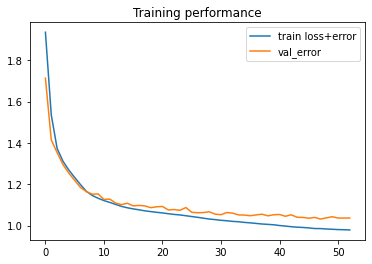

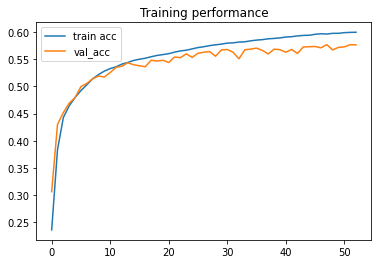

In [ ]:
plt.figure()
plt.title('Training performance')
plt.plot(trained_fc.epoch, trained_fc.history['loss'], label='train loss+error')
plt.plot(trained_fc.epoch, trained_fc.history['val_loss'], label='val_error')
plt.legend()

plt.figure()
plt.title('Training performance')
plt.plot(trained_fc.epoch, trained_fc.history['acc'], label='train acc')
plt.plot(trained_fc.epoch, trained_fc.history['val_acc'], label='val_acc')
plt.legend()

##First Derivative

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_dev_features())

cnn_model = models.Sequential()
cnn_model.add(Reshape((2,128,1), input_shape=(2,128)))
cnn_model.add(Conv2D(64,(1,3),activation='relu'))
cnn_model.add(Conv2D(16,(2,3),activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dense(10,activation='softmax'))
cnn_model.compile(optimizer=Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['acc'])
cnn_model.summary()

filepath = '/content/drive/MyDrive/Neural_Net_Models/CNN_dev.h5'
trained_cnn = cnn_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min')
              ])

done
done
done
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 126, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 124, 16)        6160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               254080    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 261,786
Trainable params: 261,786
Non-trainable params: 0
_________________________________

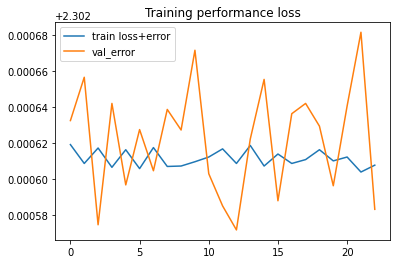

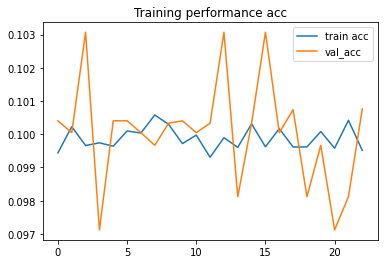

In [ ]:
plt.figure()
plt.title('Training performance loss')
plt.plot(trained_cnn.epoch, trained_cnn.history['loss'], label='train loss+error')
plt.plot(trained_cnn.epoch, trained_cnn.history['val_loss'], label='val_error')
plt.legend()

plt.figure()
plt.title('Training performance acc')
plt.plot(trained_cnn.epoch, trained_cnn.history['acc'], label='train acc')
plt.plot(trained_cnn.epoch, trained_cnn.history['val_acc'], label='val_acc')
plt.legend()

##Integral Data

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_integral_features())

cnn_model = models.Sequential()
cnn_model.add(Reshape((2,128,1), input_shape=(2,128)))
cnn_model.add(Conv2D(64,(1,3),activation='relu'))
cnn_model.add(Conv2D(16,(2,3),activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dense(10,activation='softmax'))
cnn_model.compile(optimizer=Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['acc'])
cnn_model.summary()

filepath = '/content/drive/MyDrive/Neural_Net_Models/CNN_integ.h5'
trained_cnn = cnn_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
              ])

done
done
done
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 126, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 124, 16)        6160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               254080    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 261,786
Trainable params: 261,786
Non-trainable params: 0
_________________________________

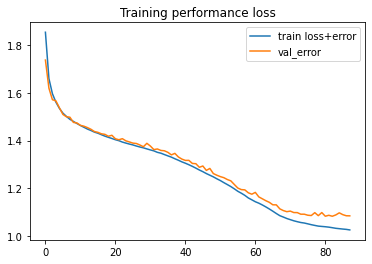

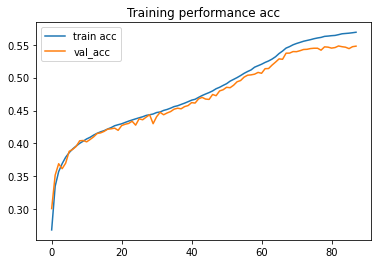

In [ ]:
plt.figure()
plt.title('Training performance loss')
plt.plot(trained_cnn.epoch, trained_cnn.history['loss'], label='train loss+error')
plt.plot(trained_cnn.epoch, trained_cnn.history['val_loss'], label='val_error')
plt.legend()

plt.figure()
plt.title('Training performance acc')
plt.plot(trained_cnn.epoch, trained_cnn.history['acc'], label='train acc')
plt.plot(trained_cnn.epoch, trained_cnn.history['val_acc'], label='val_acc')
plt.legend()

##Combinations of Raw Data, First Derivative and Integral (More Channels)

In [ ]:
train_X , train_Y , val_X , val_Y , test_X , test_Y = data_split(get_more_channels())

cnn_model = models.Sequential()
cnn_model.add(Reshape((6,128,1), input_shape=(6,128)))
cnn_model.add(Conv2D(64,(1,3),activation='relu'))
cnn_model.add(Conv2D(16,(2,3),activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dense(10,activation='softmax'))
cnn_model.compile(optimizer=Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['acc'])
cnn_model.summary()

filepath = '/content/drive/MyDrive/Neural_Net_Models/CNN_more_channels.h5'
trained_cnn = cnn_model.fit(x=train_X,
            y=train_Y,
            batch_size=1024,
            epochs=100,
            verbose=2,
            validation_data=(val_X, val_Y),
            callbacks = 
            [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')
              ])

done
done
done
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 6, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 126, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 124, 16)        6160      
_________________________________________________________________
flatten (Flatten)            (None, 9920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1269888   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,277,594
Trainable params: 1,277,594
Non-trainable params: 0
_______________________________

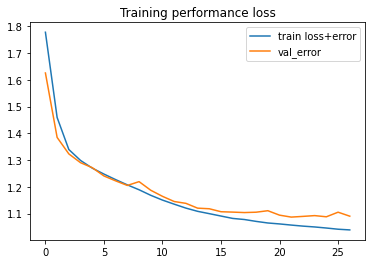

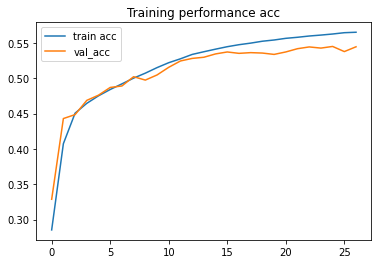

In [ ]:
plt.figure()
plt.title('Training performance loss')
plt.plot(trained_cnn.epoch, trained_cnn.history['loss'], label='train loss+error')
plt.plot(trained_cnn.epoch, trained_cnn.history['val_loss'], label='val_error')
plt.legend()

plt.figure()
plt.title('Training performance acc')
plt.plot(trained_cnn.epoch, trained_cnn.history['acc'], label='train acc')
plt.plot(trained_cnn.epoch, trained_cnn.history['val_acc'], label='val_acc')
plt.legend()